In [13]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Hypnotizability Distribution')

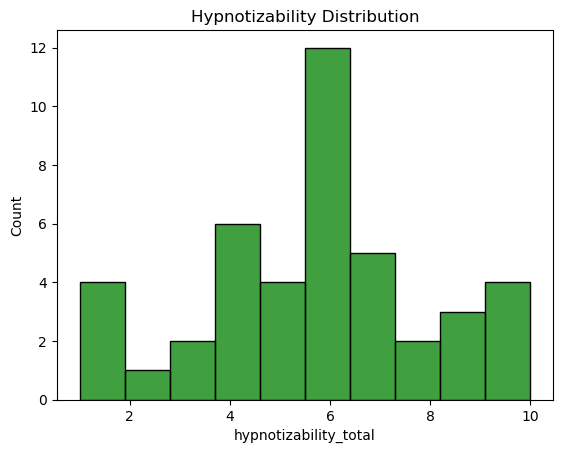

In [33]:
# open hypnotizability data
hypnotizability = pd.read_excel('data/behavioral_data/PLB_HYP_data_MASTER.xlsx').loc[9:, ['bids_id', 'hypnotizability_total']]
# hypnotizability histogram
sns.histplot(data=hypnotizability, x='hypnotizability_total', bins=10, color='green')
plt.title('Hypnotizability Distribution')

Text(0.5, 1.0, 'Hypnosis depth')

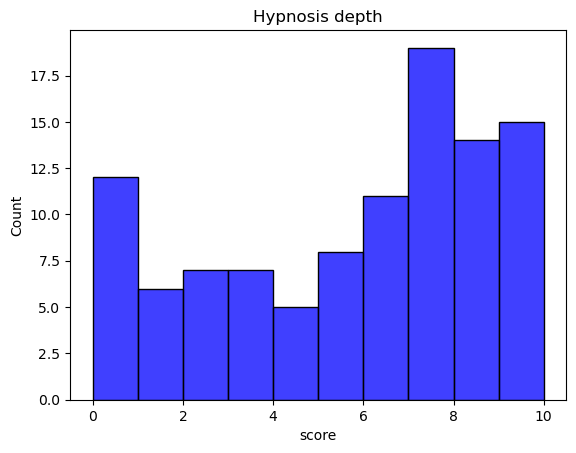

In [32]:
# open behavioral data in long format
data = pd.read_csv('data/behavioral_data/behavioral_data.csv')
data = data.query("description == 'hypnosis'")

# hypnosis depth histogram
sns.histplot(data=data, x='score', bins=10, color='blue')
plt.title('Hypnosis depth')

In [44]:
# the correlation between hypnotizability scores and hypnosis depth in all the conditions
data = pd.read_csv('data/behavioral_data/behavioral_data.csv')
data = data.query("description == 'hypnosis'").reset_index(drop=True)

hypnotizability = pd.read_excel('data/behavioral_data/PLB_HYP_data_MASTER.xlsx').loc[9:, ['bids_id', 'hypnotizability_total']]
hypnotizability = hypnotizability.loc[hypnotizability.index.repeat(2)].reset_index(drop=True)
data = data.merge(hypnotizability, on='bids_id')
data[['hypnotizability_total', 'score']].corr()

,hypnotizability_total,score
hypnotizability_total,1.000000,0.580162
score,0.580162,1.000000


<Axes: xlabel='hypnotizability_total', ylabel='score'>

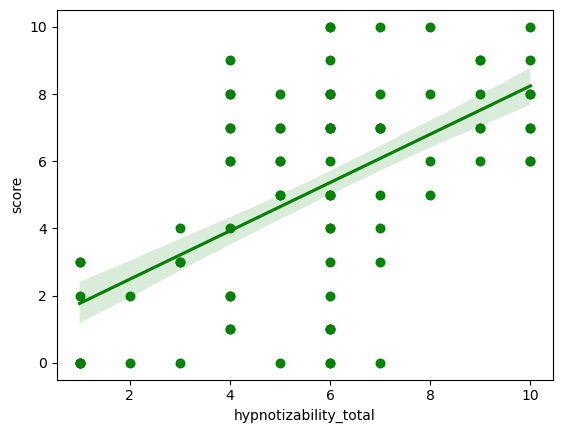

In [45]:
sns.regplot(data=data, x='hypnotizability_total', y='score', color='green')